Step 1: Import libraries

In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import numpy as np

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**Step 2: Load CSV File into Google Colab**

Load the data from the uploaded CSV file into a Pandas DataFrame.

In [2]:
from google.colab import files

uploaded = files.upload()


Saving reddit_data.csv to reddit_data.csv


Load Data
Load the data from the uploaded CSV file into a Pandas DataFrame.

In [3]:
import io

# Replace 'reddit_data.csv' with the exact name of your uploaded file if different
data_path = list(uploaded.keys())[0]  # Get the name of the uploaded file
df = pd.read_csv(io.BytesIO(uploaded[data_path]))

# Display the first few rows of the dataframe to verify loading
df.head()


,Title,Comment
0,Pulsechain is dead!!,"Prove yourself right.\n\n48,000+ validators\n\..."
1,Pulsechain is dead!!,"Idk what you're talking about, eco is thriving"
2,Pulsechain is dead!!,Didnt people say the same for HEX ? Its not a ...
3,Pulsechain is dead!!,Low quality post. It is in the top 20 chains i...
4,Pulsechain is dead!!,"No. Please, sell. You're not worth our time."


**Step 3: Data Cleaning and Preprocessing**

Cleaning the text data by normalizing, removing special characters, punctuation, URLs, emails, duplicates, and converting text to lowercase.

In [4]:
# Function to clean text by removing URLs, emails, special characters, and converting to lowercase
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'\S+@\S+', '', text)  # remove emails
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove special characters and numbers
    text = text.lower()  # lowercase text
    text = text.strip()  # remove leading/trailing whitespace
    return text

# Function to remove stopwords from text
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return ' '.join(filtered_text)

# Apply text cleaning and stopword removal to the 'Comment' column
df['cleaned_comment'] = df['Comment'].astype(str).apply(clean_text).apply(remove_stopwords)

# Drop duplicate comments
df = df.drop_duplicates(subset='cleaned_comment')

# Display the first few rows of the cleaned DataFrame
df.head()


,Title,Comment,cleaned_comment
0,Pulsechain is dead!!,"Prove yourself right.\n\n48,000+ validators\n\...",prove right validators active unique wallets h...
1,Pulsechain is dead!!,"Idk what you're talking about, eco is thriving",idk youre talking eco thriving
2,Pulsechain is dead!!,Didnt people say the same for HEX ? Its not a ...,didnt people say hex bull market right hold ra...
3,Pulsechain is dead!!,Low quality post. It is in the top 20 chains i...,low quality post top chains tvl h vol atm
4,Pulsechain is dead!!,"No. Please, sell. You're not worth our time.",please sell youre worth time


In [5]:
# Print columns of the DataFrame to check for 'cleaned_comment'
print(df.columns)

Index(['Title', 'Comment', 'cleaned_comment'], dtype='object')


**Step 4: Create Word Embeddings and Store in HDF5**

Creates word embeddings using Word2Vec and stores them in an HDF5 file to handle large datasets efficiently.*

In [6]:
# Create Word Embeddings using Word2Vec
sentences = df['cleaned_comment'].apply(word_tokenize).tolist()
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Create an HDF5 file to store Word2Vec embeddings
with h5py.File('word_embeddings.h5', 'w') as f:
    embeddings_dataset = f.create_dataset('embeddings', shape=(len(df), 100), dtype='float32')

    # Generate Word2Vec embeddings and store in HDF5
    for i, text in enumerate(df['cleaned_comment']):
        tokens = word_tokenize(text)
        token_vectors = [word2vec_model.wv[token] for token in tokens if token in word2vec_model.wv]

        if token_vectors:  # Check if there are valid token vectors
            embedding = np.mean(token_vectors, axis=0)
        else:
            embedding = np.zeros(word2vec_model.vector_size)  # Handle case with no valid tokens

        embeddings_dataset[i] = embedding


**Step 5: Load Embeddings from HDF5 and Perform TF-IDF Vectorization** (Optional)
Use HDF5 datasets or Numpy memmap for managing large arrays efficiently.

In [7]:
# Load embeddings from HDF5 file
with h5py.File('word_embeddings.h5', 'r') as f:
    embeddings = f['embeddings'][:]

# Perform TF-IDF Vectorization on the cleaned comments
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['cleaned_comment'])


**Step 6: K-Means Clustering**

In [8]:
from sklearn.cluster import KMeans

# K-Means Clustering
num_clusters = 3  # Change this to 2 if you want binary classification
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)  # Explicitly set n_init
df['Cluster'] = kmeans.fit_predict(X)

**Step 7: Add Class Labels**




In [9]:
# Adding class labels
df['Label'] = df['Cluster'].map({0: 'positive', 1: 'negative', 2: 'neutral'})  # Modify according to your clusters

**Step 8: Visualize Clusters Using Trucated SVD**

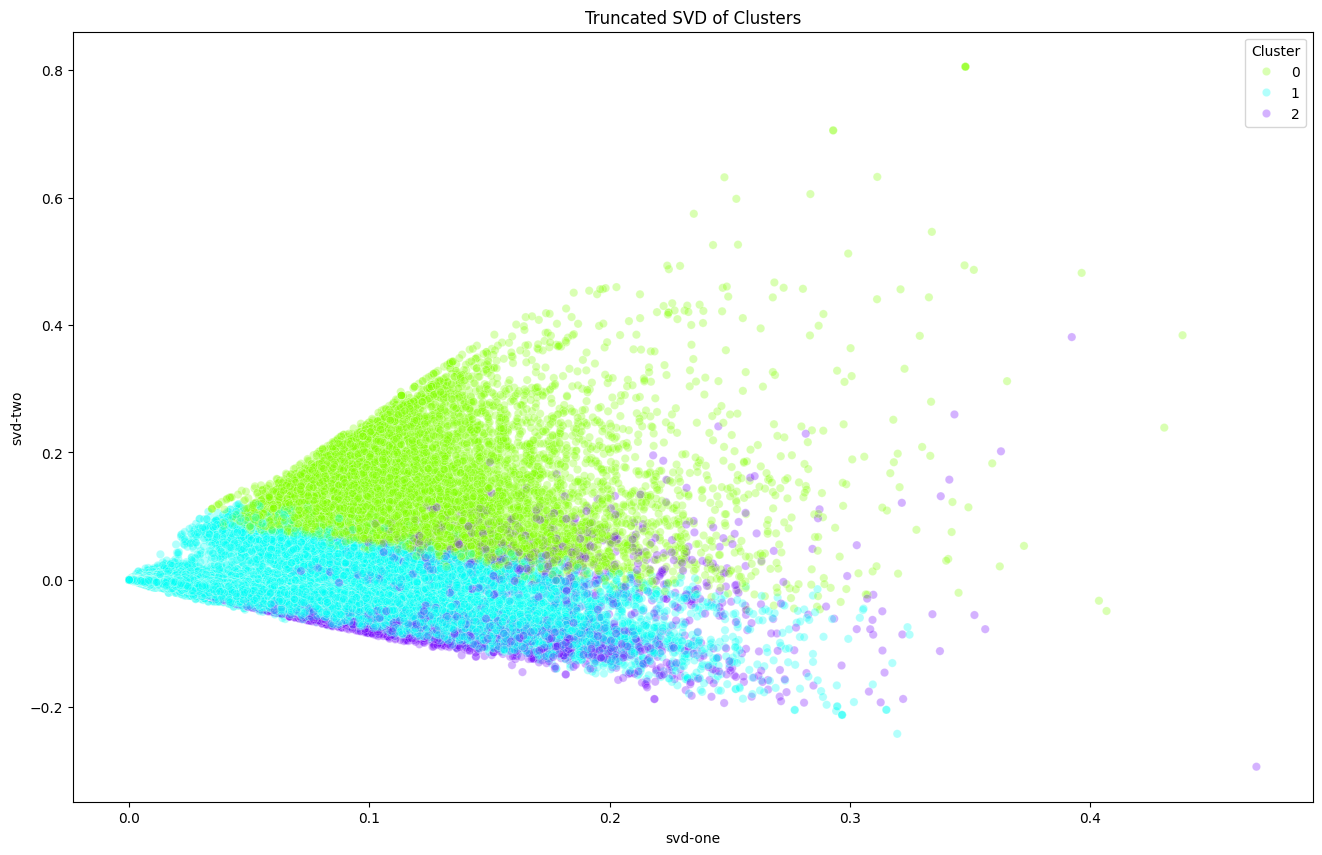

In [10]:
from sklearn.decomposition import TruncatedSVD

# Initialize Truncated SVD
svd = TruncatedSVD(n_components=2, random_state=42)

# Perform Truncated SVD
svd_result = svd.fit_transform(X)

# Add SVD results to the dataframe
df['svd-one'] = svd_result[:, 0]
df['svd-two'] = svd_result[:, 1]

# Plot SVD results
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="svd-one", y="svd-two",
    hue="Cluster",
    palette=sns.color_palette("hsv", num_clusters),
    data=df,
    legend="full",
    alpha=0.3
)
plt.title('Truncated SVD of Clusters')
plt.show()

**Step 9: Save the Results to CSV**


In [11]:
# Save the results to CSV
df.to_csv('labeled_reddit_comments.csv', index=False)

Download csv with results

In [12]:
from google.colab import files

# Download the file
files.download('labeled_reddit_comments.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>